## Spatial Features Vs Urban Footprint Vs Population Size

In [1]:
import sklearn
import pandas as pd
import numpy as np
import csv
import scipy.stats as stats
from statistics import pstdev
from statistics import mean
from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.datasets import make_regression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from itertools import product
import copy


### Read the Features data

In [2]:
!ls spfeas

Belize_spfeas.xlsx


In [3]:
spfeas = pd.read_excel('spfeas/Belize_spfeas.xlsx', sheet_name=0)

In [5]:
spfeas['OBJECTID'] = spfeas['OBJECTID'].astype(int)
spfeas = spfeas.set_index('OBJECTID')

In [6]:
spfeas.head()

,FID,Administra,Administ_1,Area,Urban_Rura,CTV_2018,ED_2018,Cluster_Nu,fourier_sc31_variance_mean,fourier_sc31_variance_std,...,sfs_sc51_std_sum,sfs_sc71_max_ratio_of_orthgonal_angles_mean,sfs_sc71_max_ratio_of_orthgonal_angles_std,sfs_sc71_max_ratio_of_orthgonal_angles_sum,sfs_sc31_std_mean,sfs_sc31_std_std,sfs_sc31_std_sum,sfs_sc71_min_line_length_mean,sfs_sc71_min_line_length_std,sfs_sc71_min_line_length_sum
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0,Toledo District,BLZ006,Toledo Rural,Rural,Cayes,217,665,1.871010,4.929879,...,42799652.0,140.709890,1.065200,4286729472,1.193974,1.408849,36374452.0,874775.350589,330970.948840,26650047676400
2,1,Stann Creek District,BLZ005,Stann Creek Rural,Rural,Cayes,201,602,2.608672,6.141846,...,92699568.0,140.376936,4.624142,7790784512,1.375928,1.689124,76362680.0,824859.818661,380083.243379,45778923946000
3,2,NaN,NaN,NaN,NaN,Cayes,126,0,6.380702,8.840365,...,10851945.0,139.219940,8.347895,461388384,2.413110,2.699090,7997279.0,614737.965726,486655.097810,2037301248000
4,3,NaN,NaN,NaN,NaN,Cayes,122,0,2.894536,6.357571,...,65703932.0,139.365071,12.484677,5233991680,1.457598,1.841355,54741532.0,814288.179976,388871.179731,30581389787100
5,4,NaN,NaN,NaN,NaN,Cayes,123,0,4.566548,7.459406,...,44759044.0,140.065461,2.836504,2403786496,1.953999,2.401075,33534290.0,692178.805971,461589.477238,11879088914400


Check data

Convert the GN_Code column to an integer index 

### Load World Pop Data

In [8]:
world_pop = pd.read_csv("world_pop/blz_ppp_v2b_2015_UNadj_qgis.csv")

In [9]:
world_pop['OBJECTID'] = world_pop['OBJECTID'].astype(int)
world_pop = world_pop.set_index('OBJECTID')

In [10]:
world_pop.head()

,Administra,Administ_1,Area,Urban_Rura,CTV_2018,ED_2018,Cluster_Nu,Shape_Leng,Shape_Area,_count,_sum,_mean
OBJECTID,,,,,,,,,,,,
1,Toledo District,BLZ006,Toledo Rural,Rural,Cayes,217,665,294022.358507,2.934572e+09,535.0,6.136642,0.011470
2,Stann Creek District,BLZ005,Stann Creek Rural,Rural,Cayes,201,602,431082.304407,5.345558e+09,1246.0,262.607626,0.210761
3,NaN,NaN,NaN,NaN,Cayes,126,0,69417.179782,3.192064e+08,1931.0,43.015828,0.022276
4,NaN,NaN,NaN,NaN,Cayes,122,0,247650.430790,3.617347e+09,12463.0,108.512611,0.008707
5,NaN,NaN,NaN,NaN,Cayes,123,0,240469.134053,1.652992e+09,1942.0,1265.180093,0.651483


In [14]:
# Total Population size

In [12]:
np.sum(world_pop['_sum'])

344026.97329303942

### Load GUF

In [13]:
guf = pd.read_csv('ghs/blz_ghs.csv')

In [15]:
guf['OBJECTID'] = guf['OBJECTID'].astype(int)
guf = guf.set_index('OBJECTID')
guf.head()

,Administra,Administ_1,Area,Urban_Rura,CTV_2018,ED_2018,Cluster_Nu,Shape_Leng,Shape_Area,ghs_count,ghs_sum,ghs_mean
OBJECTID,,,,,,,,,,,,
1,Toledo District,BLZ006,Toledo Rural,Rural,Cayes,217,665,294022.358507,2.934572e+09,2191097.0,2191297.0,1.000091
2,Stann Creek District,BLZ005,Stann Creek Rural,Rural,Cayes,201,602,431082.304407,5.345558e+09,4016469.0,4019169.0,1.000672
3,NaN,NaN,NaN,NaN,Cayes,126,0,69417.179782,3.192064e+08,241847.0,241847.0,1.000000
4,NaN,NaN,NaN,NaN,Cayes,122,0,247650.430790,3.617347e+09,2735984.0,2735984.0,1.000000
5,NaN,NaN,NaN,NaN,Cayes,123,0,240469.134053,1.652992e+09,1249474.0,1250674.0,1.000960


### Merge population data with urbanfootprint and featuures

In [16]:
guf['builtup_pct'] = guf['ghs_sum']/guf['ghs_count']
guf.describe()

,ED_2018,Cluster_Nu,Shape_Leng,Shape_Area,ghs_count,ghs_sum,ghs_mean,builtup_pct
count,723.000000,723.000000,723.000000,7.230000e+02,7.230000e+02,7.230000e+02,723.000000,723.000000
mean,2323.300138,342.637621,19208.802494,5.269802e+07,3.974239e+04,4.222773e+04,16.570927,16.570927
std,2756.359899,208.698722,39666.673437,3.006704e+08,2.263315e+05,2.263637e+05,25.267171,25.267171
min,101.000000,0.000000,469.038413,1.299014e+04,1.100000e+01,4.400000e+01,1.000000,1.000000
25%,213.500000,160.500000,1716.470797,1.367360e+05,1.020000e+02,1.358500e+03,1.017228,1.017228
50%,1226.000000,340.000000,3959.220475,5.384428e+05,4.080000e+02,4.173000e+03,1.841617,1.841617
75%,3202.000000,523.000000,22490.865522,1.760011e+07,1.333000e+04,1.741200e+04,22.592947,22.592947
max,20111.000000,707.000000,449715.444595,5.345558e+09,4.016469e+06,4.019169e+06,101.000000,101.000000


In [18]:
spfeas_world_pop_merged = spfeas.merge(world_pop, left_on='OBJECTID', right_on='OBJECTID', how='outer')
spfeas_guf_wp = spfeas_world_pop_merged.merge(guf, left_on='OBJECTID', right_on="OBJECTID", how='outer')

In [19]:
spfeas_guf_wp = spfeas_guf_wp.round(3)
spfeas_guf_wp.head()

,FID,Administra_x,Administ_1_x,Area_x,Urban_Rura_x,CTV_2018_x,ED_2018_x,Cluster_Nu_x,fourier_sc31_variance_mean,fourier_sc31_variance_std,...,Urban_Rura,CTV_2018,ED_2018,Cluster_Nu,Shape_Leng_y,Shape_Area_y,ghs_count,ghs_sum,ghs_mean,builtup_pct
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0,Toledo District,BLZ006,Toledo Rural,Rural,Cayes,217,665,1.871,4.930,...,Rural,Cayes,217,665,294022.359,2.934572e+09,2191097.0,2191297.0,1.000,1.000
2,1,Stann Creek District,BLZ005,Stann Creek Rural,Rural,Cayes,201,602,2.609,6.142,...,Rural,Cayes,201,602,431082.304,5.345558e+09,4016469.0,4019169.0,1.001,1.001
3,2,NaN,NaN,NaN,NaN,Cayes,126,0,6.381,8.840,...,NaN,Cayes,126,0,69417.180,3.192064e+08,241847.0,241847.0,1.000,1.000
4,3,NaN,NaN,NaN,NaN,Cayes,122,0,2.895,6.358,...,NaN,Cayes,122,0,247650.431,3.617347e+09,2735984.0,2735984.0,1.000,1.000
5,4,NaN,NaN,NaN,NaN,Cayes,123,0,4.567,7.459,...,NaN,Cayes,123,0,240469.134,1.652992e+09,1249474.0,1250674.0,1.001,1.001


### Filter Dataset by Builtup Surface. 

Select Rows where  builtup is greater than or equal to 10 percent

In [22]:
filter_by_builtup = spfeas_guf_wp[spfeas_guf_wp['ghs_mean']>=1]

In [23]:
filter_by_builtup.shape

(723, 465)

In [24]:
#np.sum(filter_by_builtup['stats_sum_y'])

In [202]:
#pop_density = filter_by_builtup['stats_sum_y']/filter_by_builtup['GN_area']

In [25]:
pop_count = filter_by_builtup['_sum']
np.sum(pop_count)

344026.989

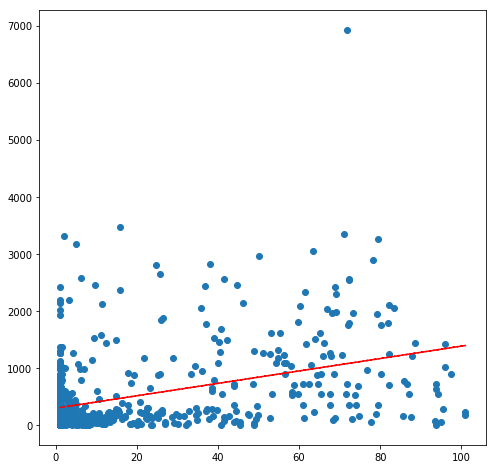

In [27]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(8,8))
y = pop_count
x = filter_by_builtup['ghs_mean']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

In [28]:
filter_by_builtup.shape

(723, 465)

### Analysis

Get the list of dependent variables from the DataFrame to store in list y_vars

In [41]:
#y_var = list(filter_by_builtup.axes[1])[440]

y_var = list(filter_by_builtup.axes[1])[463]
y_var

'ghs_mean'

Get a list of all independent variables from the DataFrame in list all_x

In [42]:
all_x = list(filter_by_builtup.axes[1])[8:440]

#Check
all_x

['fourier_sc31_variance_mean',
 'fourier_sc31_variance_std',
 'fourier_sc31_variance_sum',
 'fourier_sc71_mean_mean',
 'fourier_sc71_mean_std',
 'fourier_sc71_mean_sum',
 'fourier_sc51_mean_mean',
 'fourier_sc51_mean_std',
 'fourier_sc51_mean_sum',
 'fourier_sc31_mean_mean',
 'fourier_sc31_mean_std',
 'fourier_sc31_mean_sum',
 'fourier_sc51_variance_mean',
 'fourier_sc51_variance_std',
 'fourier_sc51_variance_sum',
 'fourier_sc71_variance_mean',
 'fourier_sc71_variance_std',
 'fourier_sc71_variance_sum',
 'gabor_sc3_filter_5_mean',
 'gabor_sc3_filter_5_std',
 'gabor_sc3_filter_5_sum',
 'gabor_sc3_filter_4_mean',
 'gabor_sc3_filter_4_std',
 'gabor_sc3_filter_4_sum',
 'gabor_sc3_filter_7_mean',
 'gabor_sc3_filter_7_std',
 'gabor_sc3_filter_7_sum',
 'gabor_sc3_filter_6_mean',
 'gabor_sc3_filter_6_std',
 'gabor_sc3_filter_6_sum',
 'gabor_sc3_filter_1_mean',
 'gabor_sc3_filter_1_std',
 'gabor_sc3_filter_1_sum',
 'gabor_sc3_mean_mean',
 'gabor_sc3_mean_std',
 'gabor_sc3_mean_sum',
 'gabor_sc

### Compute Coorelation of features with population density

Store all features with the least correlation (stat. significance (p < 0.05)) 

The Pearson correlation coefficient **measures the linear relationship
between two datasets.** Strictly speaking, Pearson's correlation requires
that each dataset be **normally distributed, and not necessarily zero-mean.**

Like other correlation coefficients, this one varies between -1 and +1
with 0 implying no correlation. Correlations of -1 or +1 imply an exact
linear relationship. Positive correlations imply that as x increases, so
does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates **the probability of an uncorrelated system**
producing datasets that have a Pearson correlation at least as extreme
as the one computed from these datasets. 

***The p-values are not entirely
reliable but are probably reasonable for datasets larger than 500 or so.***

In [43]:
filter_by_builtup[y_var] = filter_by_builtup[y_var].fillna(0)
filter_by_builtup[y_var].isnull().values.any()

False

In [44]:
y_dict = {}
x = []

for x_var in all_x:
    
    #Calculate the Pearson statistics, 
    # returns the Pearson value and p value
    
    p = stats.skew(spfeas_world_pop_merged[x_var])
    
    #print(y_var, x_var, p)
    # print back for mike
    #print (y_var + " , " + x_var + " , " +  p)

In [45]:
y_dict = {}
x = []

for x_var in all_x:
    
    #Calculate the Pearson statistics, 
    # returns the Pearson value and p value
    
    p = stats.pearsonr(filter_by_builtup[x_var],filter_by_builtup[y_var])
    
    # print back for mike
    #print (y_var + " , " + x_var + " , " +  str(p[0]) + " , " + str(p[1]))
    
    #If p < 0.05 append to list x
    if p[1] < 0.05:
        x.append([x_var,abs(p[0])])

#List x is made into a DataFrame 
# which is sorted by the absolute values of the Pearson values
x_df = pd.DataFrame(x,columns=["x_var","abs_r2"]).sort_values("abs_r2",ascending=False)


#The dependent variable dictionary is given an entry 
# where the key is the name of the dependent variable
# and the value is a list of top 200 most significant values

y_dict[y_var] = list(x_df["x_var"][0:294])
#y_dict[y_var]
#Print out each dependent variable and 
#the number of x values that remain to check completion

In [46]:
#check 

for key in y_dict.keys():
    print(key,len(y_dict[key]))


ghs_mean 294


### Correlation Significance

For each dependent variable y in the list of all dependent values, calibrate the model.
Add new key to the output dictionary where y is the dependent variable curently being processed and the values are empty for now

In [47]:
#Initialize the output dictionary, Y_D, 
# with each key being a dependent variable and the values being the results of the analyses

Y_D = {}

Y_D[y_var]={}

#Dictionary Models is used to store each result object for later use if needed

Models ={}

#Get independent variables from the variable dictionary and store in list x_vars
x_vars = y_dict[y_var]


vars_df = pd.DataFrame()

vars_df[y_var] = filter_by_builtup[y_var]


for x in x_vars:
    vars_df[x] = filter_by_builtup[x]

In [48]:
vars_df.head()

,ghs_mean,gabor_sc7_filter_11_mean,gabor_sc7_filter_9_mean,gabor_sc5_filter_9_mean,gabor_sc7_filter_13_mean,gabor_sc5_filter_11_mean,gabor_sc5_filter_7_mean,gabor_sc7_filter_7_mean,gabor_sc7_filter_5_mean,gabor_sc5_filter_5_mean,...,gabor_sc5_filter_1_sum,gabor_sc5_mean_sum,gabor_sc7_filter_3_sum,gabor_sc5_filter_3_sum,gabor_sc7_filter_1_sum,gabor_sc7_mean_sum,gabor_sc5_filter_5_sum,gabor_sc5_filter_7_sum,gabor_sc7_filter_5_sum,gabor_sc5_filter_9_sum
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,1.000,1.162,1.159,1.569,1.167,1.572,1.568,1.159,1.158,1.568,...,47780044.0,47800784.0,35283932.0,47768504.0,35304248.0,35324856.0,47774008.0,47789448.0,35290288.0,47821568.0
2,1.001,1.440,1.439,1.944,1.444,1.945,1.943,1.439,1.437,1.942,...,107701208.0,107719264.0,79654720.0,107712736.0,79675240.0,79729760.0,107771456.0,107835592.0,79756600.0,107880248.0
3,1.000,3.574,3.572,4.822,3.578,4.824,4.820,3.571,3.565,4.816,...,15940929.0,15937981.0,11796512.0,15948694.0,11792095.0,11795430.0,15961395.0,15973393.0,11815674.0,15980478.0
4,1.000,1.536,1.537,2.077,1.537,2.077,2.077,1.537,1.537,2.077,...,78013192.0,78021696.0,57713656.0,77998232.0,57757568.0,57790892.0,77998712.0,77999520.0,57721712.0,77989104.0
5,1.001,2.618,2.614,3.532,2.626,3.535,3.530,2.612,2.609,3.528,...,60514948.0,60525792.0,44739244.0,60513384.0,44772292.0,44806204.0,60539320.0,60580800.0,44777844.0,60619160.0


### Scale/Normalize Data

In [49]:
minmax_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()

names = vars_df.columns
scaled_df = minmax_scaler.fit_transform(vars_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df.head()

,ghs_mean,gabor_sc7_filter_11_mean,gabor_sc7_filter_9_mean,gabor_sc5_filter_9_mean,gabor_sc7_filter_13_mean,gabor_sc5_filter_11_mean,gabor_sc5_filter_7_mean,gabor_sc7_filter_7_mean,gabor_sc7_filter_5_mean,gabor_sc5_filter_5_mean,...,gabor_sc5_filter_1_sum,gabor_sc5_mean_sum,gabor_sc7_filter_3_sum,gabor_sc5_filter_3_sum,gabor_sc7_filter_1_sum,gabor_sc7_mean_sum,gabor_sc5_filter_5_sum,gabor_sc5_filter_7_sum,gabor_sc7_filter_5_sum,gabor_sc5_filter_9_sum
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.291994,0.292144,0.291732,0.291911,0.291902,0.292081,0.291933,0.292038,0.291752,0.292277
1,0.00001,0.017335,0.017084,0.017019,0.017146,0.017020,0.016929,0.016852,0.016859,0.016880,...,0.658204,0.658368,0.658614,0.658247,0.658791,0.659261,0.658578,0.658994,0.659383,0.659364
2,0.00000,0.150402,0.147224,0.147635,0.149242,0.148385,0.146811,0.145170,0.145447,0.146590,...,0.097408,0.097398,0.097525,0.097452,0.097489,0.097519,0.097526,0.097603,0.097673,0.097661
3,0.00000,0.023321,0.023063,0.023055,0.022903,0.023043,0.022979,0.022751,0.022902,0.022972,...,0.476765,0.476855,0.477193,0.476653,0.477561,0.477850,0.476637,0.476659,0.477207,0.476665
4,0.00001,0.090790,0.088774,0.089090,0.090313,0.089569,0.088574,0.087451,0.087679,0.088460,...,0.369824,0.369920,0.369913,0.369799,0.370190,0.370481,0.369942,0.370209,0.370192,0.370498


In [50]:
# #Create a new dataframe for scaled and centered values
# scaled_df = pd.DataFrame()

# #Scale and center the values
# scaled_df[y_var] = scale(pop_count, with_mean=True, with_std=True)


# for x in x_vars:
#     scaled_df[x] = scale(spfeas_world_pop_merged[x], with_mean=True, with_std=True)

# scaled_df = scaled_df.round(3)

In [51]:


# Y = preprocessing.minmax_scale(vars_df[y_var])
# name='pop_sum'
# Y = pd.DataFrame(Y)
# #X = pd.DataFrame()

# X = scaler.fit_transform(vars_df[x_vars])
# X = pd.DataFrame(X, columns=x_vars)
# Y.head()

In [52]:
#X.head()

### Scale the variables

### Set Elastic net's parameters

In [53]:


enet_result = ElasticNetCV(max_iter=1e8,
                    alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1],
                    l1_ratio =[.1, .5, .7, .9, .95, .99, 1],
                    verbose= False,
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)


In [54]:
scaled_df.shape

(723, 295)

In [55]:
# Fit the mode

In [56]:
#Fit the model with the scaled data
enet_result.fit(scaled_df[x_vars],scaled_df[y_var])
#Append the model to the Models dictionary
Models[y_var] = enet_result


In [57]:
enet_result

ElasticNetCV(alphas=[0.0005, 0.001, 0.01, 0.03, 0.05, 0.1], copy_X=True, cv=5,
       eps=0.001, fit_intercept=False,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=100000000.0,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='random',
       tol=0.0001, verbose=False)

In [58]:
opt_alpha, opt_l1_ratio = enet_result.alpha_, enet_result.l1_ratio_

#Print update to ensure that the script is progressing properly
print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(enet_result.score(scaled_df[x_vars],scaled_df[y_var]),
              enet_result.alpha_, enet_result.l1_ratio_))

R2: 0.67 Alpha: 0.01 l1_ratio: 0.1


Record the overall R squared score and optimal alpha 
and l1 ratio values and store them in the output dictionary


In [187]:
Y_D[y_var]['Total R2'] = enet_result.score(scaled_df[x_vars],scaled_df[y_var])
Y_D[y_var]['Alpha'] = opt_alpha
Y_D[y_var]['l1_ratio'] = opt_l1_ratio

### Ten Fold Cross validated regression

In [188]:
#Create a list R2s to store out of sample R squared values

R2s = []

#Specify the number of trials to run

trials = 10

#Run the number of trials specified in trials, 
#for each trial 66% of the observations are randomly selected to train the model
#Testing is done on the remaining 33% of observations and the R squared values are recorded

for i in range(trials):    
    X_train, X_test, y_train, y_test = train_test_split(scaled_df[x_vars],scaled_df[y_var], test_size=0.34)
    enet_regr = ElasticNetCV(max_iter=1e8,
                    alphas = [opt_alpha],
                    l1_ratio =[opt_l1_ratio],
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)
    enet_regr.fit(X_train,y_train)
    R2s.append(enet_regr.score(X_test,y_test))

#print("Mean R2: {:.2f} StDev: {:.4f}".format(mean(R2s),pstdev(R2s)))
#Record the out of sample R squared values
Y_D[y_var]['Sampling']={'trials':trials,'R2':mean(R2s),'StDev':pstdev(R2s),'R2s':R2s}
coefs = [i for i in zip(list(scaled_df[x_vars].axes[1]),enet_result.coef_)]
remaining = [i for i in coefs if abs(i[1])>0.0]
Y_D[y_var]["Coefficients"]=remaining

In [189]:
Y_D[y_var]

{'Total R2': 0.84144259277006905,
 'Alpha': 0.00050000000000000001,
 'l1_ratio': 0.10000000000000001,
 'Sampling': {'trials': 10,
  'R2': 0.83660544233584921,
  'StDev': 0.011806822457510656,
  'R2s': [0.82392195549705938,
   0.83756047751577944,
   0.84834702420234798,
   0.83802914020857078,
   0.84024993267482895,
   0.84928275651066576,
   0.84446619632069231,
   0.84119542357798061,
   0.80773164376821194,
   0.83526987308235545]},
 'Coefficients': [('hog_sc7_kurtosis_mean', 0.23862225842527751),
  ('hog_sc3_kurtosis_mean', 0.16512140694791252),
  ('hog_sc5_skew_mean', 0.22806306743886468),
  ('hog_sc5_kurtosis_mean', 0.10591321474162858),
  ('sfs_sc31_max_ll_std', -0.31747463934852593),
  ('hog_sc7_skew_mean', 0.14847150426935535),
  ('hog_sc3_variance_std', -0.14081756215379185),
  ('sfs_sc31_max_ll_mean', 0.15461207653406889),
  ('hog_sc3_skew_mean', 0.009935719177287243),
  ('fourier_v2_sc31_mean_mean', 0.25786248407313278),
  ('sfs_sc31_mean_mean', -0.0015313720477132769),
  